In [31]:
import kagglehub
import pandas as pd
from pathlib import Path

#Download the dataset
path = kagglehub.dataset_download("abhi8923shriv/sentiment-analysis-dataset")
print("Path to dataset files:", path)

data_dir = Path(path)
train_data = pd.read_csv(data_dir / "train.csv", encoding="latin1")
test_data  = pd.read_csv(data_dir / "test.csv",  encoding="latin1")

#Combine into dataframe
df = pd.concat([train_data, test_data], ignore_index=True)

df.head()
inputs = []
targets = []

for _, row in df.iterrows():
    text = str(row["text"]).strip().lower()
    characters = list(text)
    inputs.append(characters)

    raw_target = row["sentiment"]

    if isinstance(raw_target, str):
        label = raw_target.lower()
    else:
        if raw_target == 1:
            label = "positive"
        elif raw_target == 0:
            label = "negative"
        else:
            label = "neutral"

    targets.append(label)

print("Example inputs/targets:")
for i in range(3):
    print(f"{i}: {''.join(inputs[i][:60])!r} -> {targets[i]}")


Path to dataset files: C:\Users\Lucas\.cache\kagglehub\datasets\abhi8923shriv\sentiment-analysis-dataset\versions\9
Example inputs/targets:
0: 'i`d have responded, if i were going' -> neutral
1: 'sooo sad i will miss you here in san diego!!!' -> negative
2: 'my boss is bullying me...' -> negative


In [32]:
import transformers
print(transformers.__version__)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)

def normalize_label(raw_target):
    if isinstance(raw_target, str):
        lab = raw_target.lower()
        if "neg" in lab:
            return "negative"
        elif "pos" in lab:
            return "positive"
        else:
            return "neutral"
    else:
        if raw_target == 1:
            return "positive"
        elif raw_target == 0:
            return "negative"
        else:
            return "neutral"

df_model = df[["text", "sentiment"]].copy()
df_model["label_str"] = df_model["sentiment"].apply(normalize_label)

label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}
df_model["labels"] = df_model["label_str"].map(label2id)

train_df, val_df = train_test_split(
    df_model[["text", "labels"]],
    test_size=0.2,
    random_state=42,
    stratify=df_model["labels"],
)

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))

model_name = "roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(batch):
    texts = batch["text"]

    if isinstance(texts, str):
        texts = [texts]

    texts = ["" if t is None else str(t) for t in texts]

    return tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=128,
    )

train_tok = train_ds.map(tokenize_fn, batched=True, remove_columns=["text"])
val_tok   = val_ds.map(tokenize_fn,   batched=True, remove_columns=["text"])

train_tok.set_format("torch")
val_tok.set_format("torch")

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
)

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from sklearn.metrics import f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loader = DataLoader(train_tok, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_tok,   batch_size=64)

optimizer = AdamW(model.parameters(), lr=2e-5)

def eval_macro_f1(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in data_loader:
            labels = batch["labels"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return f1_score(all_labels, all_preds, average="macro")

num_epochs = 10
patience = 3
best_f1 = 0.0
wait = 0
best_state = None

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        labels = batch["labels"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels, 
        )
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)

    avg_loss = total_loss / len(train_tok)
    val_f1 = eval_macro_f1(model, val_loader)
    print(f"Epoch {epoch:02d} | train_loss={avg_loss:.4f} | val_macroF1={val_f1:.4f}")

    if val_f1 > best_f1 + 1e-4:
        best_f1 = val_f1
        best_state = model.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch}, best macro F1 = {best_f1:.4f}")
            break

if best_state is not None:
    model.load_state_dict(best_state)
    print(f"Loaded best model with macro F1 = {best_f1:.4f}")
else:
    print("No improvement, using last epoch model.")


4.51.3


Map: 100%|███████████████████████████████████████████████████████████████| 6460/6460 [00:00<00:00, 31045.17 examples/s]
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 

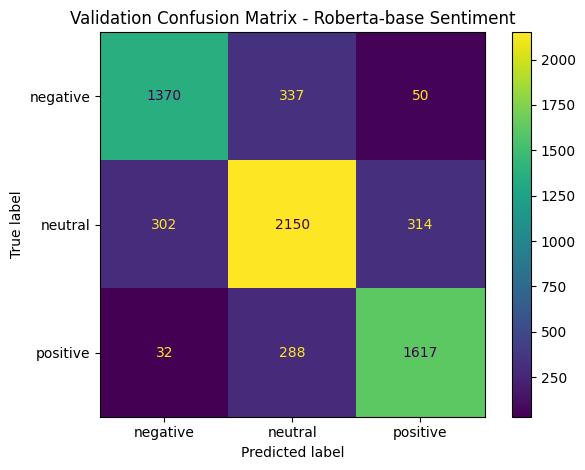

              precision    recall  f1-score   support

    negative       0.80      0.78      0.79      1757
     neutral       0.77      0.78      0.78      2766
    positive       0.82      0.83      0.83      1937

    accuracy                           0.80      6460
   macro avg       0.80      0.80      0.80      6460
weighted avg       0.80      0.80      0.80      6460



In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in val_loader: 
        labels = batch["labels"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[id2label[i] for i in range(len(id2label))]
)
disp.plot(values_format="d")
plt.title("Validation Confusion Matrix - Roberta-large Sentiment")
plt.tight_layout()
plt.show()

print(classification_report(all_labels, all_preds, target_names=[id2label[i] for i in range(len(id2label))]))
